# Evaluation des Neuronalen Netzes zur Giraffenpuzzle-Erkennung
Das Notebook [Giraffenpuzzle-Training](https://www.kaggle.com/code/toedtlifhsg/giraffenpuzzle-training?scriptVersionId=187781292) produzierte als Ausgabe ein fertig trainiertes neuronales Netz, sowie eine Aufsplittung des Giraffenpuzzleteile-Datensatzes in einen Trainings- und einen Testdatensatz. Hier wollen wir das Modell laden und auf dem Testdatensatz evaluieren.

In [73]:
import matplotlib.pyplot as plt #Plottingroutinen zur Visualisierung
import numpy as np # Arrays- "The fundamental package for scientific computing with Python" 
import pandas as pd #Umgang mit Tabellen- hier nur zum Laden der Klassenlabels
import tensorflow as tf #Tensorflow, trainieren von neuronale Netzen (inkl. Keras)
import shutil # Dateisystemmanipulationen, insbesondere für das Kopieren von Dateien
from pathlib import Path #Pathlib, Umgang mit Dateipfaden
import scikitplot # Visualisierungen von Klassifikationsperformanz
from scikitplot.metrics import plot_confusion_matrix

In [74]:
# Modell laden:
loaded_model = tf.keras.models.load_model('../04_Training/Model/model_Gipfeli_testing.keras')
# Excel-Datei mit Angabe, ob ein Bild ein Test- oder ein Trainingsbild ist:
train_or_test = pd.read_excel('../04_Training/train_test_split.xlsx')
train_or_test.columns = ['Dateiname','TrainOrTest']



Wir erstellen nun zwei Baumstrukturen (für Trainings- und Testdaten). Das Klassenlabel extrahieren wir aus dem Dateinamen- hier ist es alles vor dem ersten Underscore, "_".

In [75]:
# Extrahiere Klassenlabel aus Dateiname
Klassenlabel = train_or_test['Dateiname'].map(lambda s: s[:s.find('_')] if not s.startswith('.') else None)
train_or_test = train_or_test[Klassenlabel.notna()]
Klassenlabel = Klassenlabel[Klassenlabel.notna()]
train_or_test['Klasse'] = Klassenlabel

testbilder = train_or_test[train_or_test['TrainOrTest'] == 'test']
testbilder = testbilder[~testbilder['Klasse'].str.startswith('.', na=False)]
y_test = Klassenlabel.loc[testbilder.index]

# Kopiere die Testbilder in eine Baumstruktur
for irow,row in testbilder.iterrows():
    Dateiname,TrainOrTest,Klasse = (row.Dateiname,row.TrainOrTest,row.Klasse)

    # jede Datei mit ".DS_Store" im Namen überspringen
    if "DS_Store" in Dateiname:
        continue

    fullfilename = Path('../02_Alle_Gipfel')/Dateiname
    Baumstrukturpfad = Path('./')/'test'
    (Baumstrukturpfad/Klasse).mkdir(exist_ok=True,parents=True)
    shutil.copyfile(fullfilename,Baumstrukturpfad/Klasse/Dateiname)

    #TODO: Code kann massiv gekürzt werden -> Test Ordner bereits vorhanden

In [76]:
image_size=(128,128)
batch_size=32
test_ds = tf.keras.utils.image_dataset_from_directory(
    Baumstrukturpfad,  #es ist wichtig, dass zur Validierung keine Testdaten verwendet werden!
    validation_split=0.0,
    #subset="validation",
    shuffle=False, # Das ist wichtig, da wir später die Bilder in der gleichen Reihenfolge aus dem Dataset extrahieren müssen, in der wir sie dem Modell zur prediction gefüttert haben.
    seed=123,
    image_size=image_size,
    batch_size=batch_size)

Found 70 files belonging to 3 classes.


tf.Dataset ist eine Tensorflowklasse, welche effizient Trainingsbilder aus der Baumstruktur lädt.

In [77]:
L = [x for x in test_ds] # wir extrahieren die Testbilder aus dem Dataset
#X_test = [x.numpy().shape for x,y in L]
X_test = np.vstack([x.numpy() for x,y in L])
y_test = np.hstack([y.numpy() for x,y in L])
X_test.shape,y_test.shape

((70, 128, 128, 3), (70,))

Wir überprüfen, dass zumindest das erste Bild in Xtest dem ersten eintrag in der testbilder-Liste entspricht:

In [78]:
valid_testbilder = [f for f in sorted(testbilder.Dateiname) if "DS_Store" not in f]
testbildname = valid_testbilder[0]
dfrow = testbilder[testbilder.Dateiname==testbildname]
testbildklasse = dfrow.Klasse.iloc[0]
dfrow

,Dateiname,TrainOrTest,Klasse
99,Buttergipfel_light_01.jpg,test,Buttergipfel


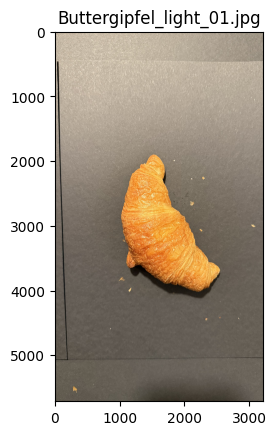

In [79]:
testbild1 = plt.imread(Baumstrukturpfad/testbildklasse/testbildname)
plt.imshow(testbild1)
plt.title(testbildname);

Das entsprechende Bild in `X_test` wurde zentriert, d.h. die Farben stimmen nicht mehr:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


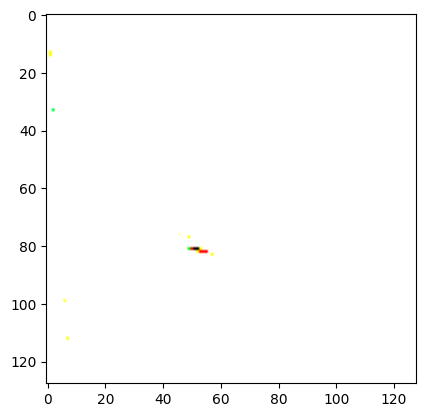

In [80]:
plt.imshow(X_test[0]);

Die obigen zwei Bilder könnten das gleiche Bild sein (jenes unten ist so, wie es das neuronale Netz in etwa sieht...). D.h. wir verstehen nun die Reihenfolge der Predictions: 

In [81]:
yhat_test = loaded_model.predict(X_test)
yhatnum_test = yhat_test.argmax(axis=1)
yhat_test.shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


(70, 3)

In [82]:
y_test,yhatnum_test

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2]))

Das ist nun also der Klassenindex- da wir die Bilder nicht "geshuffled" haben, ist zumindest die Sequenz `y_test` monoton. Bei `yhatnum_test` (also unseren Vorhersagen auf diesen Bildern) gibt es einige wenige Abweichungen. Das ist zu erwarten. Wenn wir nur wüssten, welcher Klasse das zugehört?!  
Aber weil wir zu neugierig sind, wie gut das Modell sein könnte, rechnen wir ohne dieses Wissen mal die Genauigkeit aus:

In [83]:
Genauigkeit = np.mean(np.where(y_test==yhatnum_test,1,0)) 
# np.where könnte man auch weglassen, so: Genauigkeit = np.mean(y_test==yhatnum_test). 
# Aber was ist der Mittelwert von True, False, True? 
# Klarer ist's wenn wir mit where ersetzen: True->1 und False->0
assert Genauigkeit==np.mean(y_test==yhatnum_test) # Ergibt einen Fehler, sollte das mal nicht mehr stimmen
print(f'Die Testgenauigkeit ist {100*Genauigkeit:3.1f}%.')

Die Testgenauigkeit ist 100.0%.


Nun würden wir also auch gerne die Label kennen. Wir müssen den Labelindex (die Zahl) mit dem Namen der Klasse in Verbindung bringen. Zum Glück werden die Klassenlabel sortiert durchgezählt, so dass dieser Schritt nicht schwer ist:

In [84]:
sorted_class_labels = np.array(sorted(Klassenlabel.unique())) #Labels in Keras der Funktion image_dataset_from_directory werden immer alphanummerisch sortiert den Indices zugeordnet
sorted_class_labels

array(['Buttergipfel', 'Keimkraft', 'Laugengipfel'], dtype='<U12')

In [85]:
yhat_label = pd.Series(sorted_class_labels[yhatnum_test],index=testbilder.index)
y_test_label = pd.Series(sorted_class_labels[y_test],index=testbilder.index)
# das vorhergesagte Label:
yhat_label

98     Buttergipfel
99     Buttergipfel
100    Buttergipfel
106    Buttergipfel
107    Buttergipfel
           ...     
169    Laugengipfel
170    Laugengipfel
171    Laugengipfel
172    Laugengipfel
173    Laugengipfel
Length: 70, dtype: object

In [86]:
# und das Tatsächliche:
y_test_label

98     Buttergipfel
99     Buttergipfel
100    Buttergipfel
106    Buttergipfel
107    Buttergipfel
           ...     
169    Laugengipfel
170    Laugengipfel
171    Laugengipfel
172    Laugengipfel
173    Laugengipfel
Length: 70, dtype: object

In [87]:
# Natürlich muss die gleiche Genauigkeit rauskommen, wenn wir sie mit den Labels berechnen, anstatt mit den Labelindices:
Genauigkeit2 = (yhat_label==y_test_label).mean()
print(f'Die Testgenauigkeit ist {100*Genauigkeit2:3.1f}%.')

Die Testgenauigkeit ist 100.0%.


Schliesslich können wir uns noch die Wahrscheinlichkeit merken, mit welcher das Neuronale Netz eine Klasse identifiziert hat. Dies ist also die grösste Zahl unter den $P(y=c_i|X)$ für alle Klassen $c_1$,...,$c_C$ ($C$ der Anzahl Klassen unseres Problems, `yhat_test.shape[1]`.

In [88]:
P = np.max(yhat_test,axis=1)
P.shape

(70,)

# Scikit-Plot
Wir sind bereit! Wir kennen die Testbilder, deren zugehörige Klassenlabel und Vorhersagen durch das geladene Modell. Wir folgen der Dokumentation [hier](https://scikit-plot.readthedocs.io/en/stable/metrics.html). Berechnen wir Metriken! Wir beginnen mit der Confusion Matrix:

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

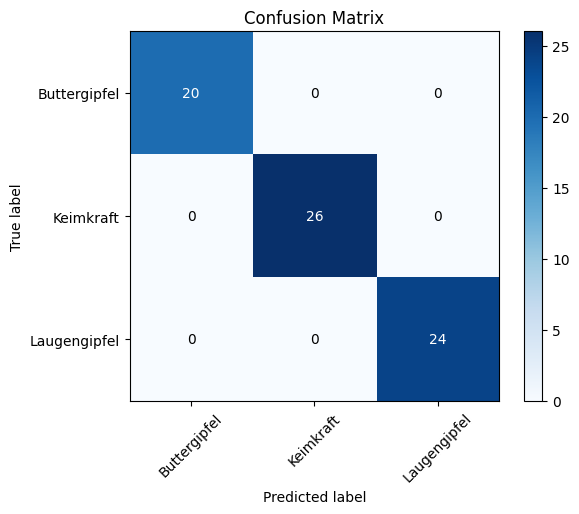

In [89]:
plot_confusion_matrix(y_test_label,yhat_label,labels=sorted_class_labels,x_tick_rotation=45)

Beachten Sie, wie hübsch blockdiagonal die confusion matrix geworden ist. Dies zeigt, dass das Modell sich meist in der Form, und selten bis nie in der Farbe irrt.  
Ein offensichtliches Problem ist natürlich, dass wir den Grossteil der Daten zum Training benutzt haben (das ist gängige Praxis), und nun nur wenige Beispiele (pro Klasse) übrig haben, um die Präzision und den Recall der Klasse zu schätzen. Mehr Daten wären schon praktisch...

In [90]:
display((y_test_label==yhat_label).value_counts())
print('-'*30)
for curr_class_str in yhat_label.unique():
    curr_class_results=(y_test_label[y_test_label==curr_class_str]==yhat_label[y_test_label==curr_class_str])
    print(f'{curr_class_str:<10}:{100*curr_class_results.mean():3.0f}%')

True    70
Name: count, dtype: int64

------------------------------
Buttergipfel:100%
Keimkraft :100%
Laugengipfel:100%


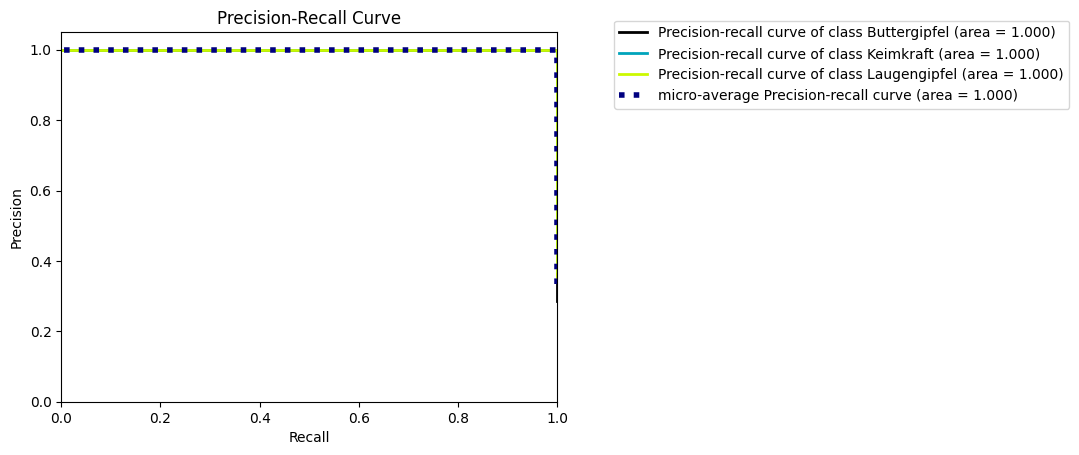

In [91]:
ax = plt.subplot(1,1,1)
scikitplot.metrics.plot_precision_recall(y_test_label,yhat_test,ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05)); #Legende ausserhalb des Plots- sonst sieht man nichts

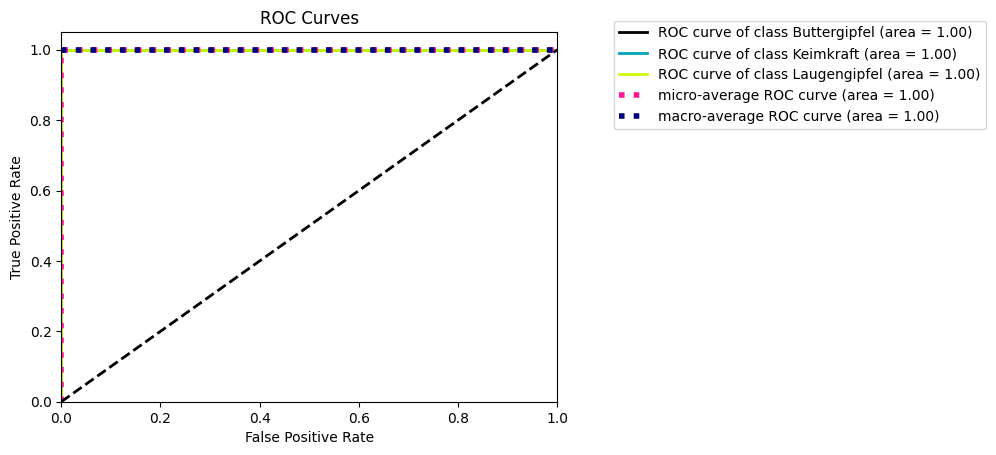

In [92]:
ax = plt.subplot(1,1,1)
scikitplot.metrics.plot_roc(y_test_label,yhat_test,ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05)); #Legende ausserhalb des Plots- sonst sieht man nichts

Ein Problem hier ist, dass das neuronale Netz für recht viele Klassen ("area=1.000") eine extreme Precision-Recall-Kurve ausgibt- von (0,1) über (1,1) nach (1,0). Aber wer würde sich schon darüber beklagen!

Zur Erinnerung, dies ist das Modell, das die obigen Resultate erziehlt hat. Wir können es grundsätzlich irgendwo (auf einem Raspberry-Pi?) laden und dort Vorhersagen generieren.

In [93]:
loaded_model 

<Functional name=Gipfellisucher, built=True>